<a href="https://colab.research.google.com/github/haitongw/MIE1517_Project/blob/main/distracted_driver_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIE 1517 Project : Distracted Driver Detection

Team 25: Haitong Wang, Jianping Zhou, Jinrui Gu, Zeren Shen

According to the CDC motor vehicle safety division, one in five car accidents is caused by a distracted driver. Sadly, this translates to 425,000 people injured and 3,000 people killed by distracted driving every year.

Therefore, we want to build a distracted driver detection model to detect if a driver get distracted while driving. We believe an effective model can improve driving safety in real world.

## Data Loading and Splitting

Our dataset is from a Kaggle competition: https://www.kaggle.com/c/state-farm-distracted-driver-detection/

In this dataset, there are ten different classes, including
* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

There are 22424 samples in the dataset. We split it into training, validation and test set with the percentage of 80%, 10%, 10%.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import copy
import time
from distutils.dir_util import copy_tree

from scipy.stats import mode

In [ ]:
torch.manual_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/MIE\ 1517\ Project/training\ set.zip

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

data_dir = '/content/training set/train'
splitfolders.ratio(data_dir, output="output", ratio=(0.8, 0.1, 0.1)) 

Copying files: 22424 files [00:06, 3221.47 files/s]


In [ ]:
train_dir = '/content/output/train'
val_dir = '/content/output/val'
test_dir = '/content/output/test'

# classes are folders in each directory with these names
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [ ]:
# load and transform data using ImageFolder

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), 
                                                          (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num test images: ', len(test_data))

Num training images:  17934
Num validation images:  2237
Num test images:  2253


In [ ]:
def get_dataloader(batch_size):
    loader = {}
    loader['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                                shuffle=True)
    loader['val'] = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                             shuffle=True)
    loader['test'] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                              shuffle=True)
    return loader

In [ ]:
loader = get_dataloader(64)

## Data Visualization 

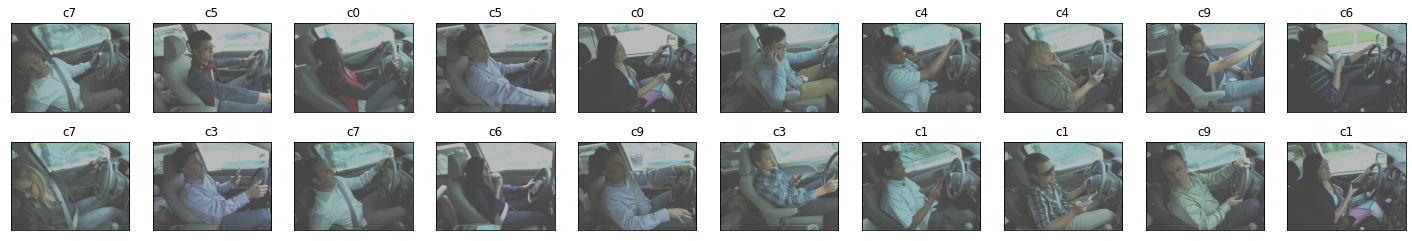

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(loader['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
images = 1 / (1 + np.exp(-images))

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
dataset = pd.read_csv('driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


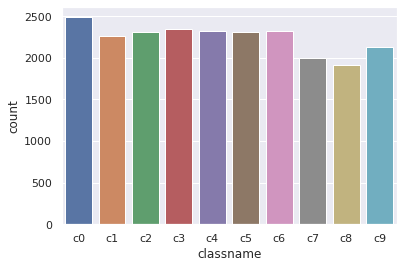

In [ ]:
# Number of images by category

import seaborn as sns

sns.set_theme(style="darkgrid")
sns.countplot(x = 'classname', data=dataset)

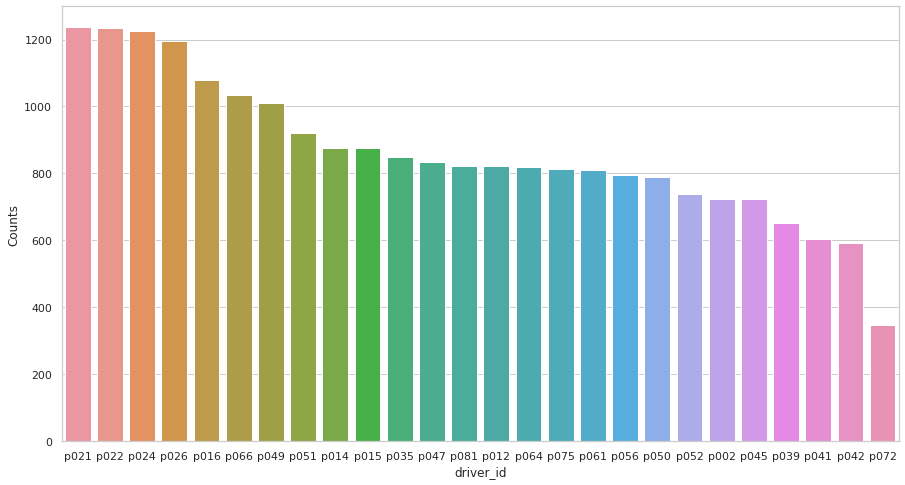

In [ ]:
# Find the frequency of images per driver

drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']

plt.figure(figsize=(15,8))
sns.barplot(x="driver_id",y="Counts", data = drivers_id)

## Data Augmentation

ILLUSTRATION OF TRANSFORMS: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

**Original Images**

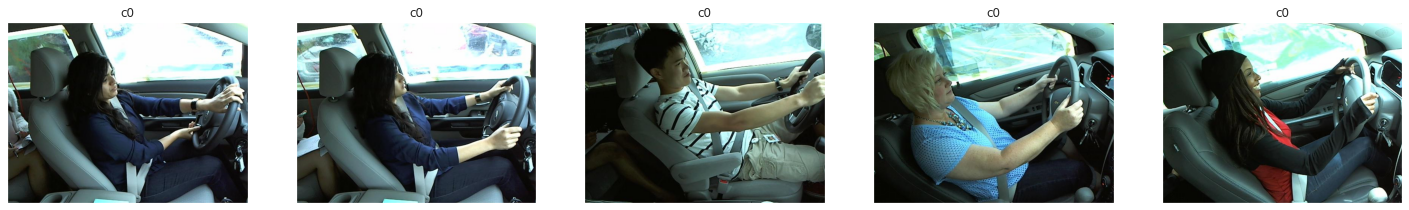

In [ ]:
# train_data_Orig

data_transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                           num_workers=0, shuffle=False)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

**Random Perspective**

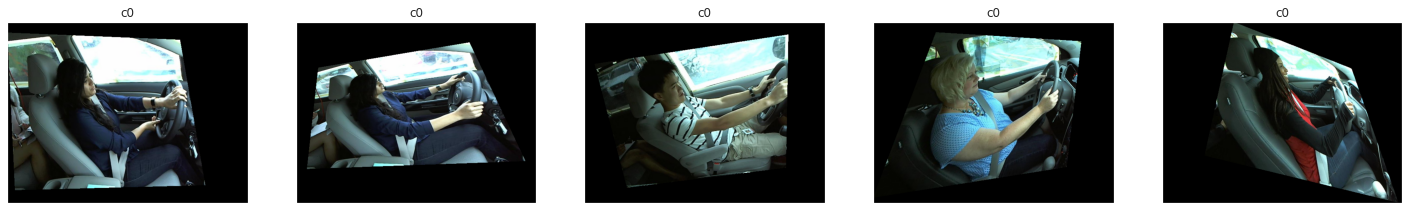

In [ ]:
# train_data_RandomPerspective

data_transform_RandomPerspective = transforms.Compose([transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
                                                       transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=data_transform_RandomPerspective)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                           num_workers=0, shuffle=False)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

**ColorJitter**

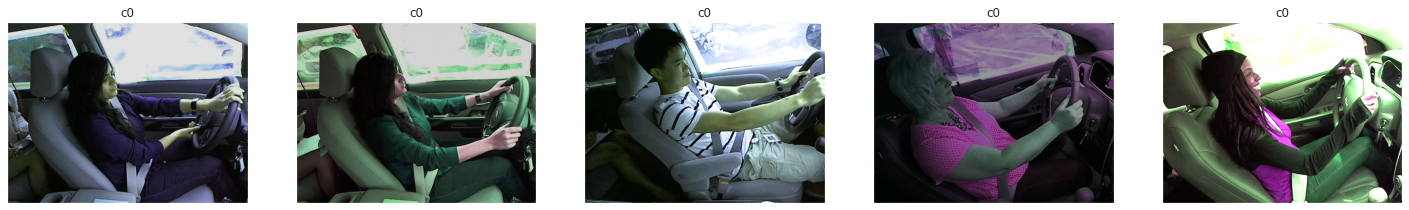

In [ ]:
# data_transform_ColorJitter

data_transform_ColorJitter = transforms.Compose([transforms.ColorJitter(brightness=.5, hue=.3),
                                                 transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=data_transform_ColorJitter )
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                           num_workers=0, shuffle=False)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

**Random Crop**

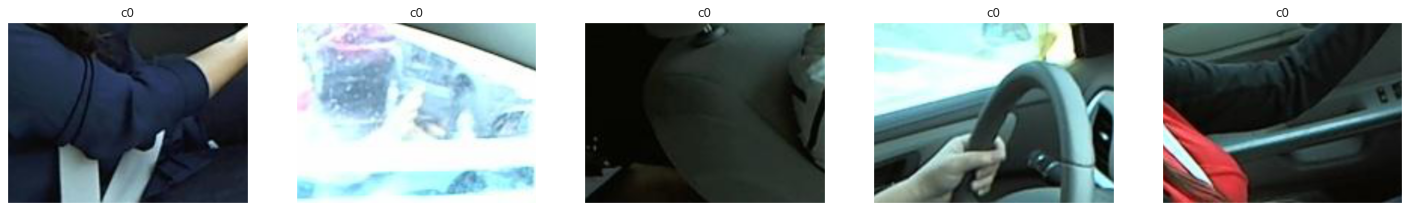

In [ ]:
# data_transform_RandomCrop

data_transform_RandomCrop = transforms.Compose([transforms.RandomCrop(size=(120, 160)),
                                                transforms.Resize([480, 640]),
                                                transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=data_transform_RandomCrop)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                           num_workers=0, shuffle=False)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

**Concatenating Datasets**

In [ ]:
# Concatenating datasets

data_transform = transforms.Compose([transforms.ToTensor()])
data_transform_RandomPerspective = transforms.Compose([transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
                                                       transforms.ToTensor()])
data_transform_ColorJitter = transforms.Compose([transforms.ColorJitter(brightness=.5, hue=.3),
                                                 transforms.ToTensor()])
data_transform_RandomCrop = transforms.Compose([transforms.RandomCrop(size=(120, 160)),
                                                transforms.Resize([480, 640]),
                                                transforms.ToTensor()])

train_data_Orig = datasets.ImageFolder(train_dir, transform=data_transform)
train_data_RandomPerspective = datasets.ImageFolder(train_dir, transform=data_transform_RandomPerspective)
train_data_ColorJitter = datasets.ImageFolder(train_dir, transform=data_transform_ColorJitter)
train_data_RandomCrop = datasets.ImageFolder(train_dir, transform=data_transform_RandomCrop)
train_data = torch.utils.data.ConcatDataset([train_data_Orig, train_data_RandomPerspective, train_data_ColorJitter, train_data_RandomCrop])

# print out some data stats
print('Num training images: ', len(train_data))

Num training images:  71736


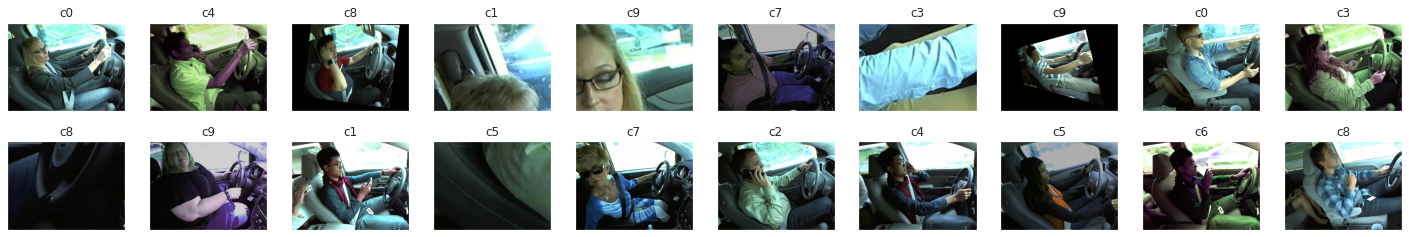

In [ ]:
# Visualize data augmentation

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Models

In this section, we defined several models. We use transfer learning in this task, our models are based on pretrained **AlexNet**, **MobileNetv2**, **ResNet18** and **VGG16**.

Besides, to achieve best performance, we want to ensemble different neural networks. We plan to use weighted majority algorithm to combine outputs from the models we have trained.


Tips: This is not our final model. We may continue to train different models and fine tune our existing models. The existing ensemble model only uses a simple majority vote method. We will try weighted majority in the next few weeks.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
!nvidia-smi

cuda:0
Wed Mar 16 16:40:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [ ]:
def train(args, net=None):
    """
    train the neural networks
    Args:
        args, dictionary containing all the arguments used in training
            args.model(str): Class name of the model
            args.num_epochs(int): number of epochs
            args.batch_size(int): batch size
            args.learning_rate(float): learning rate
            args.save_checkpoints(bool): save checkpoints
            args.save_dir_driver(str): saving directory in google drive
            args.verbose(bool): print intermediate losses and accuracy
            args.plot(bool): plot training curve and validation curve
            args.experiment_name(str): experiment name, used as folder name
        net, neural net to be trained
    Return:
        The best neural net in the training
    """

    dataloaders = get_dataloader(args.batch_size)

    dataset_sizes = {}
    dataset_sizes['train'] = len(train_data)
    dataset_sizes['val'] = len(val_data)
    # dataset_sizes['test'] = len(test_data)

    save_dir = "output/" + args.experiment_name + "/"
    save_dir_driver = args.save_dir_driver + args.experiment_name + '/'

    # if path does not exist, create one
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(save_dir_driver):
        os.makedirs(save_dir_driver)

    # load net
    if net is None:
        Net = globals()[args.model]
        net = Net()

    net.to(device) # send to GPU
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=args.learning_rate)

    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0

    start_time = time.time()

    train_accs, train_losses = [], []
    val_accs, val_losses = [], []

    for epoch in range(args.num_epochs):
        print('-' * 10)
        print(f"epoch {epoch}/{args.num_epochs-1}")

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # training mode
            else:
                net.eval()  # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                #track history only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_accs.append(epoch_acc.cpu().detach())
                train_losses.append(epoch_loss)
            else:
                val_accs.append(epoch_acc.cpu().detach())
                val_losses.append(epoch_loss)

            if args.verbose:
                end_str = ',' if phase == 'train' else '\n'
                print(f"{phase} Loss: {epoch_loss} Acc:{epoch_acc}", end=end_str)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc 
                best_model_wts = copy.deepcopy(net.state_dict())
            
            # save checkpoints every epoch
            if args.save_checkpoints:
                checkpoints_dir = save_dir + f"model_{net.name}_bs_{args.batch_size}_lr_{args.learning_rate}_epoch_{epoch}"
                torch.save(net.state_dict(), checkpoints_dir)
                copy_tree(save_dir, save_dir_driver)    # save to google driver
                
        # if (epoch + 1) % 10 == 0 and args.save_checkpoints:
        #     copy_tree(save_dir, save_dir_driver)

    time_elapsed = time.time() - start_time
    print()
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc}')

    # save accuracy and loss, then copy all the data to google driver
    if args.save_checkpoints:
        np.savetxt(save_dir + f"model_{net.name}_train_acc.csv", train_accs)
        np.savetxt(save_dir + f"model_{net.name}_train_loss.csv", train_losses)
        np.savetxt(save_dir + f"model_{net.name}_val_acc.csv", val_accs)
        np.savetxt(save_dir + f"model_{net.name}_val_loss.csv", val_losses)
        copy_tree(save_dir, save_dir_driver)    # save to google driver

    # plot training curve vs validation curve
    if args.plot:
        train_accs = np.array(train_accs)
        val_accs = np.array(val_accs)
        train_losses = np.array(train_losses)
        val_losses = np.array(val_losses)

        plt.plot(np.arange(args.num_epochs, step=1), train_accs, label='train')
        plt.plot(np.arange(args.num_epochs, step=1), val_accs, label='val')
        plt.title("Train vs Validation Accuracy")
        plt.legend()
        plt.show()
        plt.plot(np.arange(args.num_epochs, step=1), train_losses, label='train')
        plt.plot(np.arange(args.num_epochs, step=1), val_losses, label='val')
        plt.title("Train vs Validation Loss")
        plt.legend()
        plt.show()

    # load the best model
    net.load_state_dict(best_model_wts)

    return net

### AlexNet

In [ ]:
class AlexModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'alexnet'
        
        alex = models.alexnet(pretrained=True)  # load Alexnet
        for param in alex.parameters():
            param.requires_grad = False         # freeze all the network

        self.features = alex.features           # use the convolutional layers
        self.conv1 = nn.Conv2d(256, 256, 5, 2)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(256 * 2 * 4, 256)
        self.linear2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.features(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 256 * 2 * 4)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = x.squeeze()
        return x


In [ ]:
args = AttrDict()
args_dict = {
    'model': "AlexModel",
    'num_epochs': 1,
    'batch_size': 128,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/gdrive/MyDrive/MIE 1517 Project/output/",
    'verbose': True,
    'plot': False,
    'experiment_name': "alexnet"
}
args.update(args_dict)
cnn = train(args)

----------
epoch 0/0
train Loss: 0.51137058914768 Acc:0.8418088546894168,val Loss: 0.06800645771596679 Acc:0.9803308001788109
Training complete in 4.0m 18.54066514968872s
Best val Acc: 0.9803308001788109


----------
epoch 0/1
train Loss: 9.763521989007133 Acc:0.35374149659863946,val Loss: 0.9950570913633705 Acc:0.6137684398748324
----------
epoch 1/1
train Loss: 0.601744774227572 Acc:0.783149325303892,val Loss: 0.4092552060919997 Acc:0.8672329012069736
Training complete in 5.0m 43.2973895072937s
Best val Acc: 0.8672329012069736


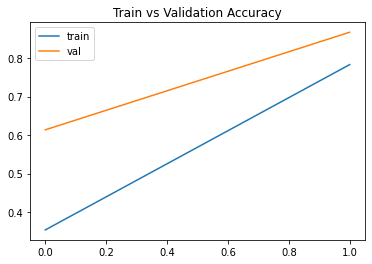

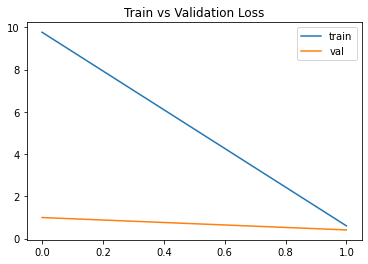

In [ ]:
args = AttrDict()
args_dict = {
    'model': "AlexModel",
    'num_epochs': 2,
    'batch_size': 256,
    'learning_rate': 0.01,
    'save_checkpoints': True,
    'save_dir_driver': "/content/gdrive/MyDrive/MIE 1517 Project/output/",
    'verbose': True,
    'plot': True,
    'experiment_name': "example_2"
}
args.update(args_dict)
cnn = train(args)

### MobileNet V2


In [ ]:
class MobileNet_V2_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'MobileNet_V2'
        
        self.cnn = models.mobilenet_v2(pretrained=True)
        self.cnn.classifier = nn.Linear(1280, 10)

    def forward(self, x):
        return self.cnn(x)

In [ ]:
args = AttrDict()
args_dict = {
    'model': "MobileNet_V2_Model",
    'num_epochs': 2,
    'batch_size': 16,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/",
    'verbose': True,
    'plot': False,
    'experiment_name': "example_1"
}
args.update(args_dict)
cnn = train(args)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

----------
epoch 0/1
train Loss: 0.2824379193643383 Acc:0.9135719861715178,val Loss: 0.15847562650983815 Acc:0.9490388913723737
----------
epoch 1/1
train Loss: 0.11556010999286521 Acc:0.9659306345489015,val Loss: 0.07431859185541974 Acc:0.9789897183728208

Training complete in 13.0m 23.826667547225952s
Best val Acc: 0.9789897183728208


### MobileNet V3_small


In [ ]:
class mobilenetv3small(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'mobilenet_v3_small'
        
        mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)  # load Alexnet
        for param in mobilenet_v3_small.parameters():
            param.requires_grad = False         # freeze all the network

        self.net = mobilenet_v3_small           # use the convolutional layers
        self.cla = nn.Linear(1000,10)
        #self.net.fc = nn.Linear(1024, 10)
    
    def forward(self, x):
        x = self.net(x)
        x = self.cla(x)
        x = x.squeeze()
        return x

----------
epoch 0/19
train Loss: 2.2247489947757955 Acc:0.24021411843425897,val Loss: 1.941338651991338 Acc:0.32811801519892714
----------
epoch 1/19
train Loss: 1.678468493656449 Acc:0.44764135162261626,val Loss: 1.6243926093788301 Acc:0.4202056325435852
----------
epoch 2/19
train Loss: 1.4338900141988802 Acc:0.539032006245121,val Loss: 1.382862095967115 Acc:0.6048278945015646
----------
epoch 3/19
train Loss: 1.2319800543242692 Acc:0.6290844206535073,val Loss: 1.1877474609527623 Acc:0.6016987036209209
----------
epoch 4/19
train Loss: 1.1340635483435355 Acc:0.6543994647039144,val Loss: 1.1995102026977333 Acc:0.5949932945909701
----------
epoch 5/19
train Loss: 1.0670496558909088 Acc:0.6700122672019627,val Loss: 0.983731194537934 Acc:0.707644166294144
----------
epoch 6/19
train Loss: 0.9803537178613861 Acc:0.701460912233746,val Loss: 1.0242814459755958 Acc:0.645507375949933
----------
epoch 7/19
train Loss: 0.9534260435514895 Acc:0.7033567525370804,val Loss: 0.8843433170324998 Acc:

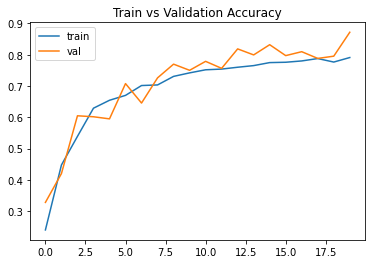

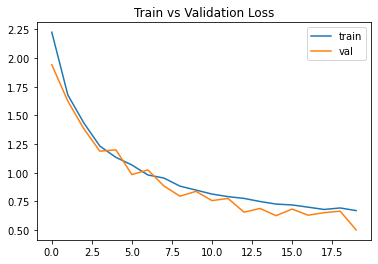

In [ ]:
args = AttrDict()
args_dict = {
    'model': "mobilenetv3small",
    'num_epochs': 20,
    'batch_size': 128,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/gdrive/MyDrive/MIE 1517 Project/output/",
    #'save_dir_driver': "D:/ML project/output/",
    'verbose': True,
    'plot': True,
    'experiment_name': "example_mobilenetv3_small"
}
args.update(args_dict)
cnn = train(args)

### resnet18


In [ ]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
#Classifier architecture to put on top of resnet18
for param in resnet.parameters():
    param.requires_grad = False 
from collections import OrderedDict
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,100)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(100,10)),
    ('output', nn.LogSoftmax(dim=1))
]))

resnet.fc = fc

In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
args = AttrDict()
args_dict = {
    'model': "resnet",
    'num_epochs': 10,
    'batch_size': 128,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/gdrive/MyDrive/MIE 1517 Project/output/",
    'verbose': True,
    'plot': False,
    'experiment_name': "example_1"
}
args.update(args_dict)
cnn = train(args)

----------
epoch 0/9
train Loss: 0.8453965911873743 Acc:0.7887253261960522,val Loss: 0.7647865563830895 Acc:0.8113544926240501
----------
epoch 1/9
train Loss: 0.7287705906447565 Acc:0.8134827701572432,val Loss: 0.6776975204116487 Acc:0.8301296379079124
----------
epoch 2/9
train Loss: 0.6354645484065722 Acc:0.8389650942344151,val Loss: 0.6159791068461626 Acc:0.8381761287438534
----------
epoch 3/9
train Loss: 0.5725782608605686 Acc:0.8502286160365786,val Loss: 0.5319218446913179 Acc:0.8672329012069736
----------
epoch 4/9
train Loss: 0.5178498765344642 Acc:0.8617709378833501,val Loss: 0.5467590629175192 Acc:0.8350469378632097
----------
epoch 5/9
train Loss: 0.4782926191836413 Acc:0.8710828593732575,val Loss: 0.46828669329599765 Acc:0.8685739830129638
----------
epoch 6/9
train Loss: 0.4360554225471116 Acc:0.8843537414965986,val Loss: 0.41667830305915887 Acc:0.8931604827894501
----------
epoch 7/9
train Loss: 0.4095080765783687 Acc:0.8893163822906212,val Loss: 0.3785966694701395 Acc:0

### VGG16

In [ ]:
class VGGModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'vgg16'
        
        vgg = models.vgg16(pretrained=True)  # load VGGNet
        for param in vgg.parameters():
            param.requires_grad = False         # freeze all the network

        self.features = vgg.features           # use the convolutional layers
        self.conv1 = nn.Conv2d(512, 512, 5, 2)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(512 * 3 * 4, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 10)

        
    def forward(self, x):
        x = self.features(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 512 * 3 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze()

        return x

In [ ]:
args = AttrDict()
args_dict = {
    'model': "VGGModel",
    'num_epochs': 5,
    'batch_size': 32,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/gdrive/MyDrive/MIE 1517 Project/output/",
    'verbose': True,
    'plot': True,
    'experiment_name': "vggnet"
}
args.update(args_dict)
cnn = train(args)

### Ensemble Model

We plan to use weighted majority algorithm in the final version. But for progress report, we just implement a simple majority vote algorithm.

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.name = 'ensemble'
        self.num_models = len(models)
        self.models = models


In [ ]:
def ensemble_pred(model, x):
    """
    majority vote
    """
    model.to(device)
    model.eval()
    x = x.to(device)

    with torch.set_grad_enabled(False):    
        out = model.models[0](x)
        _, pred = torch.max(out, 1)
        pred = pred[None, :]    # add one dimension

        for i in range(1, model.num_models):
            out = model.models[i](x)
            _, new_pred = torch.max(out, 1)
            new_pred = new_pred[None, :]
            pred = torch.cat((pred, new_pred), dim=0)
    
    pred = pred.cpu().detach().numpy()
    majority = mode(pred)[0].squeeze()  # find the most frequent element in each column
    majority = torch.from_numpy(majority).to(device)    

    return majority    

##  Evaluation 

Is this section, we load our trained models and evaluate their performance using test set.

In [ ]:
# load model
def load_model(args):
    """
    args:
        experiment_name(str): should be the same experiment name as used in training
        model_name(str): defined by the model class
        batch_size(int): batch size
        lr(float): learning rate
        epoch(int): the epoch you want to load
    return:
        loaded model
    """
    Model = globals()[args.model]
    model = Model()

    checkpoint_name = f"model_{model.name}_bs_{args.batch_size}_lr_{args.learning_rate}_epoch_{args.epoch}"
    experiment_dir = f"/content/gdrive/MyDrive/MIE 1517 Project/output/{args.experiment_name}/"
    model_path = experiment_dir + checkpoint_name
    model_state = torch.load(model_path)

    model.load_state_dict(model_state)

    return model

In [ ]:
# load AlexNet
args = AttrDict()
args_dict = {
    'model': "AlexModel",
    'epoch': 0,
    'batch_size': 128,
    'learning_rate': 0.001,
    'experiment_name': "alexnet"
}
args.update(args_dict)
alex = load_model(args)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# load MobileNet V2
args = AttrDict()
args_dict = {
    'model': "MobileNet_V2_Model",
    'epoch': 1,
    'batch_size': 16,
    'learning_rate': 0.001,
    'experiment_name': "model_MobileNet_V2_bs_16_lr_0.001"
}
args.update(args_dict)
mobilev2 = load_model(args)

In [ ]:
# load MobileNet V3_small
args = AttrDict()
args_dict = {
    'model': "mobilenetv3small",
    'epoch': 20,
    'batch_size': 128,
    'learning_rate': 0.001,
    'experiment_name': "example_mobilenetv3_small"
}
args.update(args_dict)
mobilenetv3_small = load_model(args)

In [ ]:
# load ResNet18
res = models.resnet18(pretrained=True)

#Classifier architecture to put on top of resnet18
for param in res.parameters():
    param.requires_grad = False 
from collections import OrderedDict
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,100)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(100,10)),
    ('output', nn.LogSoftmax(dim=1))
]))

res.fc = fc

In [ ]:
res_state = torch.load("/content/gdrive/MyDrive/MIE 1517 Project/output/resnet18/model_resnet_bs_128_lr_0.001_epoch_7")
res.load_state_dict(res_state)

<All keys matched successfully>

In [ ]:
# load VGG16
args = AttrDict()
args_dict = {
    'model': "VGGModel",
    'epoch': 1,
    'batch_size': 32,
    'learning_rate': 0.001,
    'experiment_name': "vggnet"
}
args.update(args_dict)
vgg = load_model(args)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
def evaluate_model(model, loader):
    """
    Evaluate model performance on test set
    """
    model.eval()

    model.to(device)

    running_loss = 0.0
    running_corrects = 0
    num_samples = 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #track history only in training phase
        with torch.set_grad_enabled(False):
            if 'ensemble' in model.name:
                preds = ensemble_pred(model, inputs)
            else:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
        
        running_corrects += torch.sum(preds == labels.data).item()
        num_samples += len(inputs)

    test_acc = running_corrects / num_samples 

    return test_acc

In [ ]:
# evaluate alexnet 
alex_acc = evaluate_model(alex, loader['test'])
alex_acc

0.9831335996449179

In [ ]:
# evaluate mobilenet v2
mobilev2_acc = evaluate_model(mobilev2, loader['test'])
mobilev2_acc

0.9715934309809143

In [ ]:
# evaluate mobilenet v3_small
mobilev3_acc = evaluate_model(mobilenetv3_small, loader['test'])
mobilev3_acc

0.8686196182867288

In [ ]:
# evaluate vgg16
vgg_acc = evaluate_model(vgg, loader['test'])
vgg_acc

0.9942299156679982

In [ ]:
# evaluate resnet18
res_acc = evaluate_model(res, loader['test'])
res_acc

0.9076786506879716

In [ ]:
# ensemble model of the top 3 single models
ensemble3 = EnsembleModel([alex, mobilev2, vgg])

In [ ]:
# evaluate ensemble model 
ensemble3_acc = evaluate_model(ensemble3, loader['test'])
ensemble3_acc

0.9946737683089214

In [ ]:
# ensemble model of 4 single models and evaluate
ensemble4 = EnsembleModel([alex, mobilev2, vgg, res])
ensemble4_acc = evaluate_model(ensemble4, loader['test'])
ensemble4_acc

0.9911229471815357

According to the above results, Ensemble model of top 3 single models is the best model with test accuracy of 99.47%. VGG16-based net is the best single model with test accuracy of 99.42%.

## New Data Generation

We plan to record a short video in a car to perform real time detection to further evaluate our model performance. (By the way, we will only pretend to drive a car for safety issues.)

We plan to do this part in the next few weeks.

## Testing on New Data

# Save to HTML

In [ ]:
%%shell
jupyter nbconvert --to html /content/distracted_driver_detection.ipynb

[NbConvertApp] Converting notebook /content/distracted_driver_detection.ipynb to html
[NbConvertApp] Writing 3330884 bytes to /content/distracted_driver_detection.html
